# All analysis

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
import re
from glob import glob
import iminuit
import probfit as pf

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

/home/petrov/.local/lib/python3.7/site-packages/mplhep/__init__.py:48: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


Get events number

In [2]:
def check_equal_rows(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
        return 0
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return -1

def get_prepared_table(year='11', merge_points=[]):
    f = uproot.pandas.iterate("../../outputs/"+year+"/trees/*_*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure', 'm1', 'm2'])
    dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])
    #shape
    print('dataRAW.shape:', dataRAW.shape)
    #check different names
    dataRAW.sort_values(by='name', ascending=True, inplace=True)
    print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')
    #check trigger
    bad_trig = dataRAW.query('trigger<0')
    print('Energy points with bad trigger:\n', bad_trig.name.value_counts())
    #check energies
    bad_en = dataRAW.query('beam_energy<0')
    print('Bad energy records:', bad_en.name.shape[0])
    #remove bad trigger if non-mc
    data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')
    #remain mass in the window and non-kinfit
    data = data.query('mass>450&mass<550&procedure!=1').copy()
    print(data.shape[0], 'records left')
    data.drop(['procedure'], axis=1, inplace=True)
    #add luminosities
    lum = pd.read_csv(f'../../inputs/{year}/lum.dat')
    lum.rename({'label': 'name'}, axis=1, inplace=True)
    if 'err' in lum.columns:
        lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    lum = lum.sort_values(by='name').drop_duplicates(subset=['name'])
    
    print('Records in  lum:', lum.shape[0])
    print('Records in data:', data.name.unique().shape[0])
    set1 = set(data.name.unique())
    set2 = set(lum.name.unique())
    print('Differences in lum and data:', (set1|set2).difference(set1&set2) )
    assert lum.shape[0]==data.name.unique().shape[0]
    
    data_prep = lum.merge(data, on='name')    
    assert check_equal_rows(data_prep, data)==0
    
    print('Merge energies')
    for c in merge_points:
        data_prep.name.replace(c[0], c[1], inplace=True)
    assert check_equal_rows(data_prep, data)==0
    
    #Recalc lums in merged points
    new_lum= pd.DataFrame()
    data_for_new_lum = data_prep.drop_duplicates(subset=['name','lum']).groupby('name')
    new_lum['Emean'] = data_for_new_lum.apply(lambda x: np.average(x['beam_energy'], weights=x['lum']))
    new_lum['lum'] = data_for_new_lum.agg({'lum':'sum'})
    new_lum['dEmin'] = np.round( new_lum['Emean'] - data_for_new_lum.agg({'beam_energy':'min'})['beam_energy'], 2 )
    new_lum['dEmax'] = np.round( data_for_new_lum.agg({'beam_energy':'max'})['beam_energy'] - new_lum['Emean'], 2 )
    
    data_prep.drop(['lum', 'beam_energy'], axis=1, inplace=True)
    final_data = data_prep.join(new_lum, how='inner', on='name')
    assert check_equal_rows(final_data, data_prep)==0
    
    return final_data

Get data

In [3]:
merge_points11 = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)]
merge_points12 = [([900, 920, 936], 920), ([950, 960, 970,], 950), ([ 980, 990], 960)] #12 year
merge_points17 = [([880., 890.], 885), ([900., 910.], 905), ([920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.8], 939)] #17 year
merge_points19 = [([862.5, 875.0, 887.5, 900.0], 874), ([912.5, 925.0, 936.0, 945.0], 912), ([950.0, 951.1, 955.0], 952), 
                  ([962.5, 975.0, 978.0, 987.5], 980)] #19 year

In [4]:
%ls ../../outputs/

11/  cross_sections/  others/            radcors_replace_origin.dat*
12/  model_new_v6/    radcors_all.cpp    radcors_soft.dat
17/  model_old_v6/    radcors_all.dat*   radcors_soft_n.dat
19/  model_old_v7/    radcors_all_n.dat


In [7]:
data = get_prepared_table('19', merge_points19)

dataRAW.shape: (9552, 7)
Checking: 44 different names in 19 season
Energy points with bad trigger:
 812.5    2
800.0    2
662.5    2
850.0    1
837.5    1
775.0    1
637.5    1
Name: name, dtype: int64
Bad energy records: 0
9542 records left
Records in  lum: 44
Records in data: 44
Differences in lum and data: set()
Good. 9542 rows
Merge energies
Good. 9542 rows
Good. 9542 rows


In [8]:
grouped_data = data.groupby('name')

## Fit data

In [9]:
data

,name,mass,trigger,m1,m2,Emean,lum,dEmin,dEmax
0,537.5,496.262360,2,-1.223520,-0.663492,537.454102,1224.660,0.00,0.00
1,537.5,496.656921,2,0.941779,-2.458710,537.454102,1224.660,0.00,0.00
2,537.5,492.265991,2,-2.728939,-4.948519,537.454102,1224.660,0.00,0.00
3,537.5,502.868164,0,9.174967,-2.281440,537.454102,1224.660,0.00,0.00
4,537.5,497.135071,2,-4.066173,3.760708,537.454102,1224.660,0.00,0.00
...,...,...,...,...,...,...,...,...,...
9537,980.0,501.230133,2,7.783979,-12.690472,974.633557,8700.723,11.81,13.17
9538,980.0,488.581329,2,-3.815104,-17.969641,974.633557,8700.723,11.81,13.17
9539,980.0,491.306458,2,-0.630978,-19.009779,974.633557,8700.723,11.81,13.17
9540,980.0,482.470367,2,-2.637462,-42.072494,974.633557,8700.723,11.81,13.17


In [19]:
dic = {}
for i in grouped_data.groups:
    print(i)
    dic[i] = np.array( grouped_data.get_group(i)['m2'])#['mass'] )

537.5
550.0
550.1
562.5
575.0
587.5
600.0
612.5
612.6
625.0
637.5
641.0
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.0
775.0
787.5
800.0
812.5
825.0
837.5
850.0
874.0
912.0
952.0
980.0


In [20]:
#гаусс + гаусс + const
def gauss2(x, mu, dmu, sigma1, sigma2, f):
    return f*pf.gaussian(x, mu, sigma1) + (1-f)*pf.gaussian(x, mu-dmu, sigma2)
def const(x):
    return 1

mass_bound=(450,550)
norm_sig = pf.rename( pf.Normalized( gauss2, mass_bound ), ['x', 'M1','dM', 'S1', 'S2', 'f'] )
norm_bkg = pf.rename( pf.Normalized( const, mass_bound ), ['x'] )

ext_sig = pf.Extended(norm_sig, extname='N1')
ext_bkg = pf.Extended(norm_bkg, extname='N2')

pdf = pf.AddPdf(ext_sig, ext_bkg)
pf.describe(pdf)

['x', 'M1', 'dM', 'S1', 'S2', 'f', 'N1', 'N2']

In [21]:
# M2
M1_lms = (0., 10.03)
dM_lms = (0., 0)
S1_lms = (5.67, 7.03)
S2_lms = (11.47, 0.17)
f_lms = (0.6874, 0.5)

# Mass
# M1_lms = (497.80, 10.03)
# dM_lms = (-0.18, 0)#0.13)
# S1_lms = (5.67, 7.03)
# S2_lms = (11.47, 0.17)
# f_lms = (0.6874, 0.5)

limits = {
    "limit_M1": [M1_lms[0]-M1_lms[1], M1_lms[0]+M1_lms[1]],
    "limit_S1": [S1_lms[0]-S1_lms[1], S1_lms[0]+S1_lms[1]],
    "limit_N1": [0, 100000],
    "limit_dM": [dM_lms[0]-dM_lms[1], dM_lms[0]+dM_lms[1]],
    "limit_S2": [S2_lms[0]-S2_lms[1], S2_lms[0]+S2_lms[1]],
    "limit_N2": [0, 7000],
    "limit_f": [f_lms[0]-f_lms[1], f_lms[0]+f_lms[1]],
}
errors = {
    "error_M1": 0.1,
    "error_S1": 0.1,
    "error_N1": 10,
    "error_dM": 0,
    "error_S2": 0,
    "error_N2": 1,
    "error_f": 0,
}

In [22]:
def fitter(dic, nbins, energy, binnedLik=False):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M1": M1_lms[0], 
                          "dM": dM_lms[0], 
                          "S1": S1_lms[0], 
                          "S2": S2_lms[0],  
                          "f": f_lms[0],
                          "N1": np.size(dic), 
                          "N2": 1,
                         }
    mt = iminuit.Minuit(likelihood, **initial_par_values, **limits, **errors, pedantic=False)
    mt.migrad();
        
    likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    return mt, likelihood

In [23]:
itr = iter(dic)
fit_frame = pd.DataFrame(columns=[ 'M1', 'dM', 'S1', 'S2', 'f', 'Ns', 'Nb', 'M1_err', 'dM_err', 'S1_err', 'S2_err', 
                                  'f_err', 'Ns_err', 'Nb_err'])

In [24]:
a=1.15
k=-0.78E-3

In [25]:
def chi2ndf(lik, mt, n_par=4):
    vals = mt.values.values()
    x, y = lik.draw(no_plot=True)[0]
    x_cen = (x[1:] + x[:-1])/2
    y_pdf = pf.nputil.vector_apply(pdf, x_cen, *vals)
    chi2 = np.where(y>1, ((y-y_pdf)**2)/y, 0).sum()
    ndf = len(y[y>0]) - n_par
    return chi2, ndf

In [26]:
i = next(itr)
print('Label:', i)

Label: 537.5


Migrad quality: True
Real: 1906 Found: 1905.9791915859098


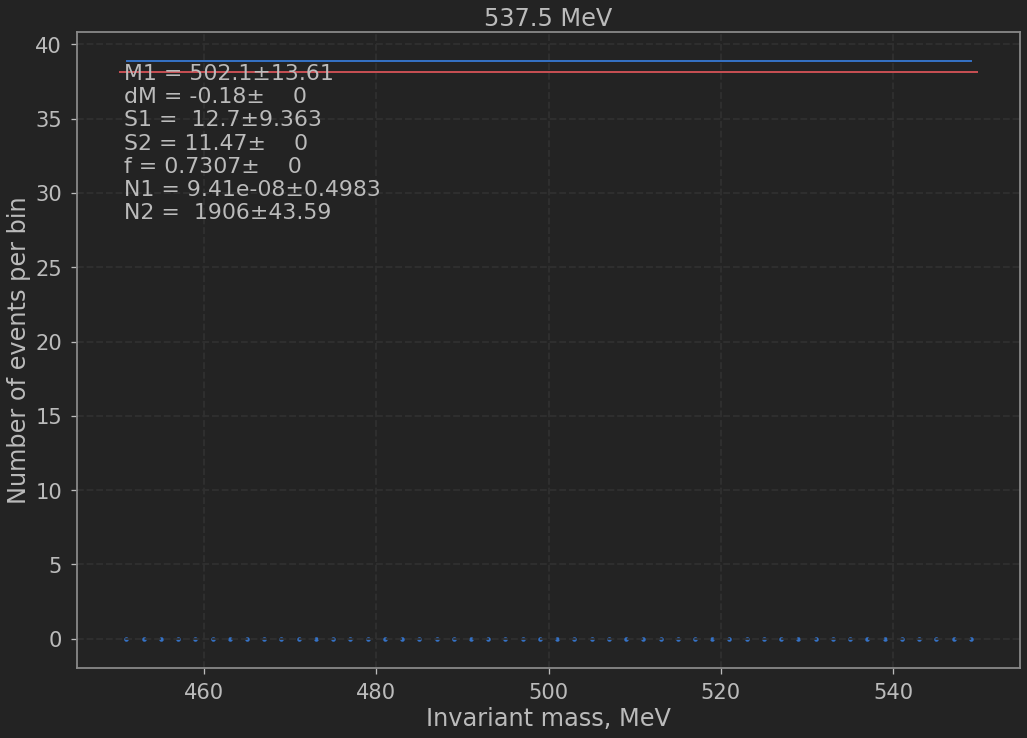

In [27]:
dicx = dic[i] #data.mass.values 
# dicx = np.hstack((dic[990.0],dic[1003.5]))
limits['limit_f'] = [k*i+a, k*i+a]
limits['limit_S1'] = [S1_lms[0]-S1_lms[1], S1_lms[0]+S1_lms[1]]
limits['limit_S2'] = [S2_lms[0], S2_lms[0]]
nbins = 50
mt, lik = fitter(dicx, nbins, i, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['N1'] + mt.values['N2'] )

vals = mt.values.values()
vals[-2] *= 1-vals[-3]
vals[-3] = 0
pf.draw_pdf(pdf, arg=vals, bound=mass_bound, bins=nbins, density=False);
my_style(f'{i} MeV','Invariant mass, MeV','Number of events per bin','--')
# plt.savefig(f'../Journal/outputs/images/allan_{i}_12.png')

In [423]:
fit_frame.tail()

,M1,dM,S1,S2,f,Ns,Nb,M1_err,dM_err,S1_err,S2_err,f_err,Ns_err,Nb_err
860,500.546134,-0.18,5.282479,11.47,0.4792,31.660199,3.343005,1.455622,0.0,1.080234,0.0,0.0,5.955388,2.673842
880,497.764752,-0.18,4.500000,11.47,0.4636,15.707991,2.286896,1.654184,0.0,0.100000,0.0,0.0,4.187791,2.028819
920,497.619141,-0.18,4.500000,11.47,0.4324,22.131639,9.869092,1.806543,0.0,0.100000,0.0,0.0,5.361022,4.059319
950,498.741803,-0.18,4.500000,11.47,0.4090,12.450282,19.570437,2.760796,0.0,0.100000,0.0,0.0,4.688151,5.394039
960,499.478888,-0.18,4.500000,11.47,0.4012,10.232338,3.766954,2.346765,0.0,0.100000,0.0,0.0,3.614222,2.568531


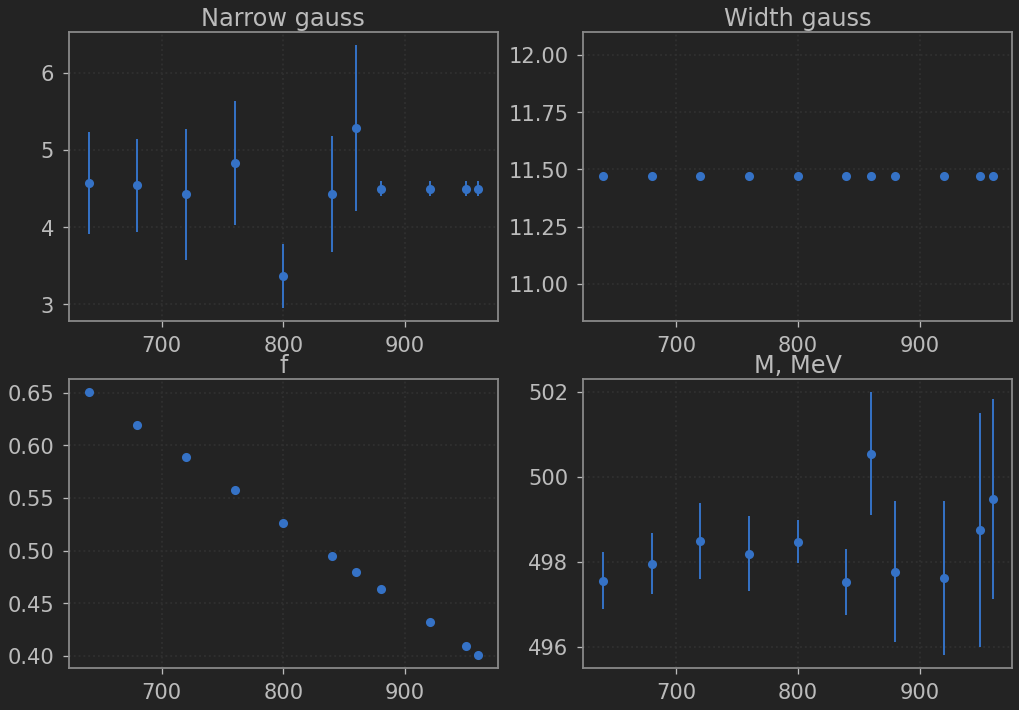

In [426]:
plt.subplot(221)
plt.errorbar(fit_frame.index, fit_frame.S1, yerr=fit_frame.S1_err, fmt='o')
my_style('Narrow gauss')
plt.subplot(222)
plt.errorbar(fit_frame.index, fit_frame.S2, yerr=fit_frame.S2_err, fmt='o')
my_style('Width gauss')
plt.subplot(223)
plt.errorbar(fit_frame.index, fit_frame.f, yerr=fit_frame.f_err, fmt='o')
my_style('f')
plt.subplot(224)
dM = fit_frame.M1
dMerr = fit_frame.M1_err
plt.errorbar(fit_frame.index, dM, yerr=dMerr, fmt='o')
my_style('M, MeV')
# plt.savefig('../Journal/outputs/images/allan_parameters_12.png')

In [349]:
def f(a,k): 
    return np.sum(((fit_frame.S1-(k*fit_frame.index + a))/fit_frame.S1_err)**2)

m = iminuit.Minuit(f)

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter a does not have initial value. Assume 0.
  after removing the cwd from sys.path.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  after removing the cwd from sys.path.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter k does not have initial value. Assume 0.
  after removing the cwd from sys.path.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: Parameter k is floating but does not have initial step size. Assume 1.
  after removing the cwd from sys.path.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: InitialParamWarning: errordef is not given. Default to 1.
  after removing the cwd from sys.path.


In [350]:
m.migrad()

------------------------------------------------------------------
| FCN = 65.63                   |      Ncalls=45 (45 total)      |
| EDM = 1.02E-17 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |    1.1    |    0.4    |            |            |         |         |       |
| 1 | k    |  0.48E-2  |  0.07E-2  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [314]:
mt.matrix(correlation=True)

--------------------------------------------------
|    |     M1     dM     S1     S2     N1     N2 |
--------------------------------------------------
| M1 |  1.000  0.008 -0.019 -0.000 -0.010  0.039 |
| dM |  0.008  1.000  0.000 -0.000  0.000 -0.000 |
| S1 | -0.019  0.000  1.000 -0.004  0.033 -0.135 |
| S2 | -0.000 -0.000 -0.004  1.000  0.001 -0.003 |
| N1 | -0.010  0.000  0.033  0.001  1.000 -0.160 |
| N2 |  0.039 -0.000 -0.135 -0.003 -0.160  1.000 |
--------------------------------------------------

Save fit_frame

In [427]:
assert len(fit_frame) == len(data.drop_duplicates(subset=['name','lum']).set_index('name'))
fit_frame = fit_frame.join( data.drop_duplicates(subset=['name','lum']).set_index('name')[['lum','dEmin','dEmax']] )

## Triggers

In [428]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

def triggers_table(data):
    triggers = data[['trigger','name']].set_index('name')
    triggers = triggers.assign(one = 1);
    triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)
    triggers.columns = ['TF', 'CF', 'TC']
    triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
    triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
    triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

    triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
    triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
    triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                                  np.square((1-triggers['eCF'])*triggers['vTF']) )
    return triggers

In [429]:
triggers = triggers_table(data)

In [430]:
fit_frame = fit_frame.join(triggers[['TrigEff','TrigErr']])

In [431]:
fit_frame.index = fit_frame.index.rename('name')

In [432]:
# fit_frame.to_csv('./data/fit_frame_12.csv')

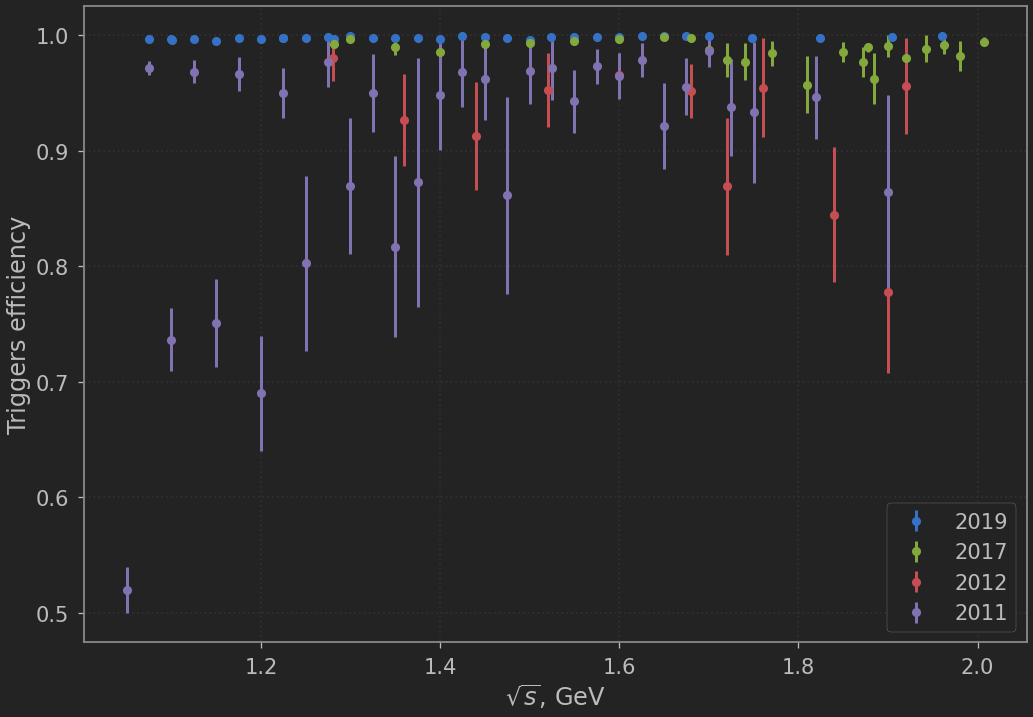

In [76]:
tr11 = pd.read_csv('./data/fit_frame_11.csv', index_col='name')[['TrigEff','TrigErr']]
tr12 = pd.read_csv('./data/fit_frame_12.csv', index_col='name')[['TrigEff','TrigErr']]
tr17 = pd.read_csv('./data/fit_frame_17.csv', index_col='name')[['TrigEff','TrigErr']]
tr19 = pd.read_csv('./data/fit_frame_19.csv', index_col='name')[['TrigEff','TrigErr']]
plt.errorbar(tr19.index*2e-3, tr19.TrigEff, yerr=tr19.TrigErr, fmt='o', lw=3, label='2019')
plt.errorbar(tr17.index*2e-3, tr17.TrigEff, yerr=tr17.TrigErr, fmt='o', lw=3, label='2017')
plt.errorbar(tr12.index*2e-3, tr12.TrigEff, yerr=tr12.TrigErr, fmt='o', lw=3, label='2012')
plt.errorbar(tr11.index*2e-3, tr11.TrigEff, yerr=tr11.TrigErr, fmt='o', lw=3, label='2011')
plt.legend();
my_style('','$\\sqrt{s}$, GeV', 'Triggers efficiency')
# plt.savefig('../Journal/outputs/images/allan_triggers.png')

## Simultaneous fit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import lib
from lib import MDVM

In [5]:
#neutral kaons
cs_n = [lib.get_KSKL_phi(), lib.get_KSKL_babar(), 
        lib.get_KSKL_up('./data/fit_frame_19.csv', './data/rad_frame.csv'),
        lib.get_KSKL_up('./data/fit_frame_17.csv', './data/rad_frame.csv'),
        lib.get_KSKL_up('./data/fit_frame_12.csv', './data/rad_frame_v6.csv'),
        lib.get_KSKL_up('./data/fit_frame_11.csv', './data/rad_frame_v6.csv')] 
#charged kaons
cs_c = [lib.get_KPKM_phi(), lib.get_KPKM_up(), lib.get_KPKM_up2()] 

In [6]:
cs_n[5].tail()

,energy,energy_err_min,energy_err_max,cs,cs_err,rad
26,1.700,0.00000,0.00000,0.229541,0.048936,0.237546
27,1.725,0.00000,0.00000,0.142231,0.038347,0.282513
28,1.750,0.00000,0.00000,0.104538,0.026273,0.340414
29,1.820,0.05084,0.04662,0.019452,0.004999,0.429742
30,1.900,0.04810,0.06312,0.028067,0.011343,0.168411


In [7]:
A = MDVM()

In [8]:
max_e = 3
def least_squares(par):
    chisq = 0
    for c in np.array(cs_n)[[0,2,3,4,5]]:
        chisq += np.square( (c.cs - A.Cross_Section_Neutral(c.energy, par))/c.cs_err )[c.energy<max_e].sum()
    for c in cs_c[:1]:
        chisq += np.square( (c.cs - A.Cross_Section_Charged(c.energy, par))/c.cs_err )[c.energy<max_e].sum()
    return chisq

In [10]:
names = ['$\\rho$', '$\\omega$', '$\\phi$', '$\\rho\'$', '$\\omega\'$', 
         '$\\phi\'$', '$\\rho\'\'$', '$\\omega\'\'$', '$\\phi\'\'$', '$\\eta$', 
         'M($\\phi\'\'$)', 'W($\\phi\'\'$)', 'M($\\phi\'$)', 'W($\\phi\'$)', 'rho4', 'Mrho4', 'Wrho4']
params = [1.354, 1.3355, 1.0393, -0.1418, -0.1885, -0.1744, 0.0547, 0.4238, 0.0312, 0.9867, 
          2193.7214, 43.4112, 1654.3024, 150.0, 0.0231, 1909.9762, 176.6471]
params = m.np_values()
fix_pars = [True, True, True, True, True, False, False, False, False, False, 
            True, True, True, True, False, True, True] # True False
error_pars = 0.05*np.array(params)

In [11]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, name=names, \
                                   error=error_pars, errordef=1)
m.get_param_states()

-------------------------------------------------------------------------------------------------
|   | Name        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------------
| 0 | $\rho$      |   1.35    |   0.07    |            |            |         |         |  yes  |
| 1 | $\omega$    |   1.34    |   0.07    |            |            |         |         |  yes  |
| 2 | $\phi$      |   1.04    |   0.05    |            |            |         |         |  yes  |
| 3 | $\rho'$     |  -0.142   |  -0.007   |            |            |         |         |  yes  |
| 4 | $\omega'$   |  -0.189   |  -0.009   |            |            |         |         |  yes  |
| 5 | $\phi'$     |  -0.174   |  -0.009   |            |            |         |         |       |
| 6 | $\rho''$    | 0.547E-1  | 0.027E-1  |            |            |         |         |       |
| 7 | $\omega''$  |   0.424   |   0.021   |            |            |         |         |       |
| 8 | $\phi''$    |  3.12E-2  |  0.16E-2  |            |            |         |         |       |
| 9 | $\eta$      |   0.99    |   0.05    |            |            |         |         |       |
| 10| M($\phi''$) |   2190    |    110    |            |            |         |         |  yes  |
| 11| W($\phi''$) |   43.4    |    2.2    |            |            |         |         |  yes  |
| 12| M($\phi'$)  |   1650    |    80     |            |            |         |         |  yes  |
| 13| W($\phi'$)  |    150    |     8     |            |            |         |         |  yes  |
| 14| rho4        |  2.31E-2  |  0.12E-2  |            |            |         |         |       |
| 15| Mrho4       |   1910    |    100    |            |            |         |         |  yes  |
| 16| Wrho4       |    177    |     9     |            |            |         |         |  yes  |
-------------------------------------------------------------------------------------------------

In [104]:
m.migrad()

------------------------------------------------------------------
| FCN = 194.4                   |     Ncalls=165 (165 total)     |
| EDM = 8.68E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
|   | Name        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------------
| 0 | $\rho$      |   1.35    |   0.07    |            |            |         |         |  yes  |
| 1 | $\omega$    |   1.34    |   0.07    |            |            |         |         |  yes  |
| 2 | $\phi$      |   1.04    |   0.05    |            |            |         |         |  yes  |
| 3 | $\rho'$     |  -0.142   |  -0.007   |            |            |         |         |  yes  |
| 4 | $\omega'$   |  -0.189   |  -0.009   |            |            |         |         |  yes  |
| 5 | $\phi'$     |  -0.174   |   0.004   |            |            |         |         |       |
| 6 | $\rho''$    |   0.055   |   0.006   |            |            |         |         |       |
| 7 | $\omega''$  |   0.424   |   0.029   |            |            |         |         |       |
| 8 | $\phi''$    |   0.031   |   0.003   |            |            |         |         |       |
| 9 | $\eta$      |   0.987   |   0.002   |            |            |         |         |       |
| 10| M($\phi''$) |   2190    |    110    |            |            |         |         |  yes  |
| 11| W($\phi''$) |   43.4    |    2.2    |            |            |         |         |  yes  |
| 12| M($\phi'$)  |   1650    |    80     |            |            |         |         |  yes  |
| 13| W($\phi'$)  |    150    |     8     |            |            |         |         |  yes  |
| 14| rho4        |  2.31E-2  |  0.10E-2  |            |            |         |         |       |
| 15| Mrho4       |   1910    |    100    |            |            |         |         |  yes  |
| 16| Wrho4       |    177    |     9     |            |            |         |         |  yes  |
-------------------------------------------------------------------------------------------------

In [105]:
print( list(m.np_values().round(4)) )

[1.354, 1.3355, 1.0393, -0.1418, -0.1885, -0.1744, 0.0547, 0.4238, 0.0312, 0.9867, 2193.7214, 43.4112, 1654.3024, 150.0, 0.0231, 1909.9762, 176.6471]


In [12]:
params = m.np_values()

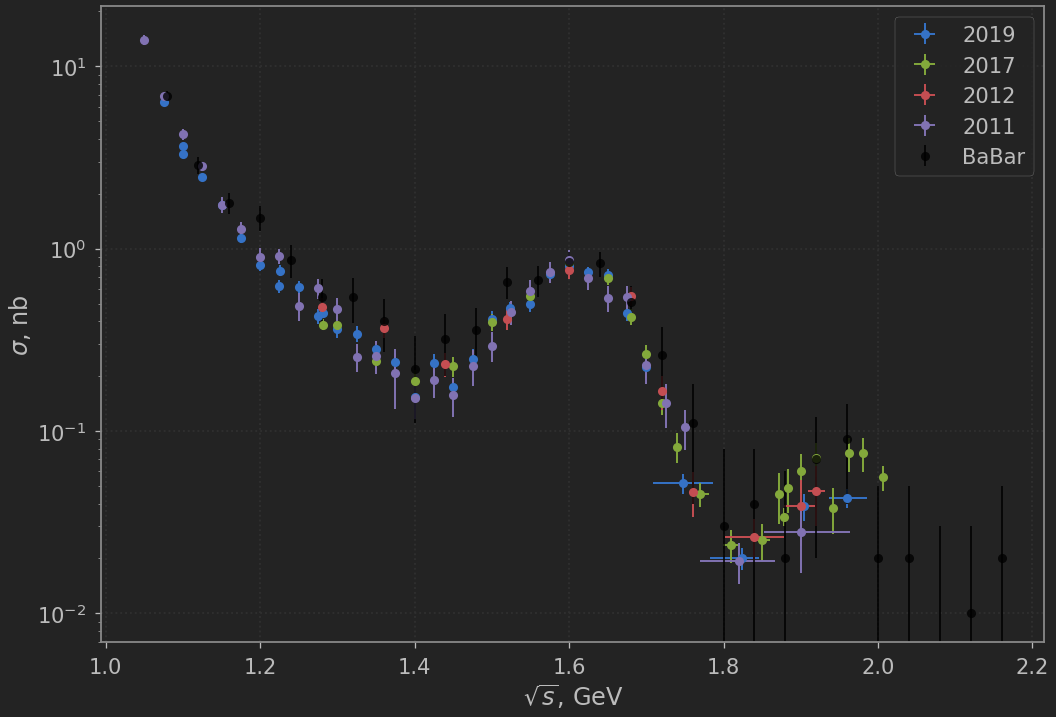

In [25]:
# lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[2], cs_n[3], cs_n[4], cs_n[5]], ['2019','2017','2012','2011'])
lib.plot_cs(None, None, [cs_n[2], cs_n[3], cs_n[4], cs_n[5]], ['2019','2017','2012','2011'])
# plt.text(1.7, 1, f'Chi2/ndf {m.fval:.2f}/{len(cs_n[2]) + len(cs_n[3]) + len(cs_n[0]) + len(cs_c[0]) - 16}');
my_style('','$\sqrt{s}$, GeV', '$\sigma$, nb')
# lib.plot_cs(A.Cross_Section_Charged, params, cs_c[0])#, cs_c[2])
# plt.savefig('../Journal/outputs/images/allan_cs_babar.png')

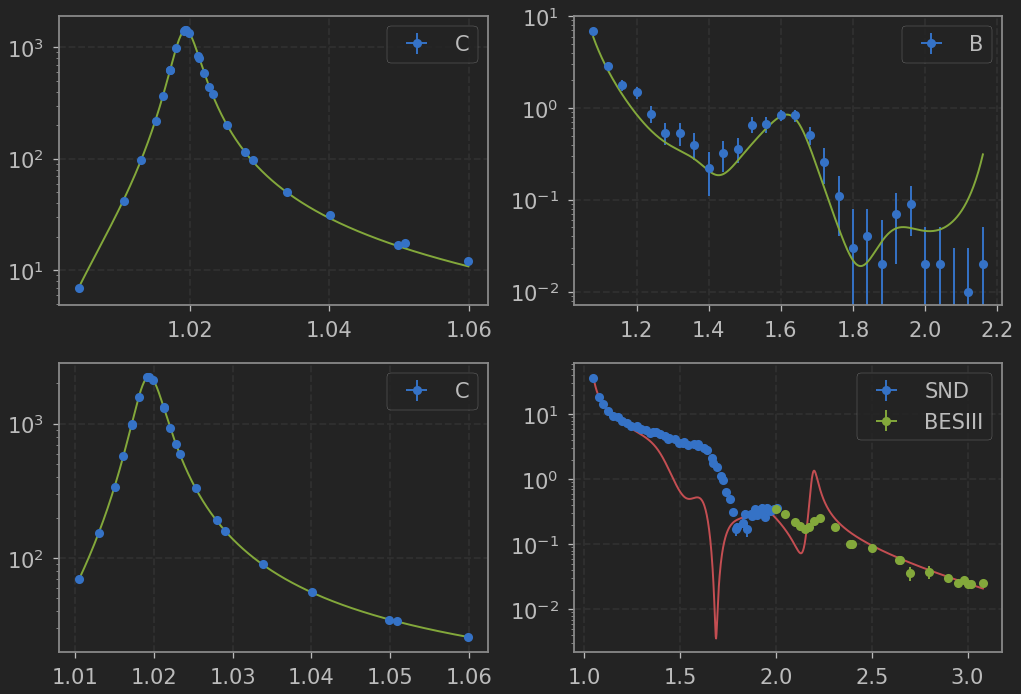

In [95]:
plt.subplot(221)
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[0]], 'CMD3')

plt.subplot(222)
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[1]], 'Babar')
# lib.plot_cs(cs_n[2], A.Cross_Section_Neutral, params)

plt.subplot(223)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[0]], 'CMD3')

plt.subplot(224)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[1], cs_c[2]], ['SND', 'BESIII'])

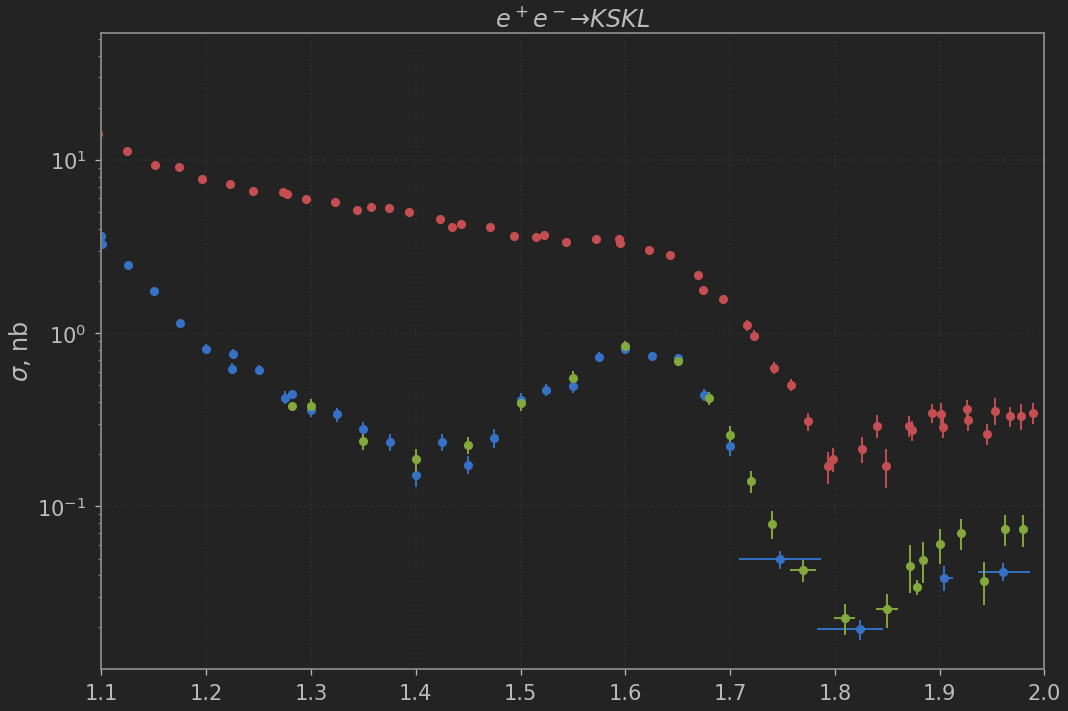

In [33]:
# plt.subplot(211)
lib.plot_cs(A.Cross_Section_Neutral, params, cs_n[2], cs_n[3])
plt.xlim(1.1, 2);
my_style('$e^+e^- \\to KSKL$','', '$\\sigma$, nb')

# plt.subplot(212)
lib.plot_cs(A.Cross_Section_Charged, params, cs_c[1])
my_style('$e^+e^- \\to K^+K^-$ (SND)', '$\\sqrt{s}$, GeV', '$\\sigma$, nb')

In [14]:
x = np.linspace(0.48*2, 2., 1000)
y = A.Cross_Section_Neutral(x, params)

/spoolA/petrov/research/uproot/lib/lib.py:194: RuntimeWarning: invalid value encountered in power
  w = np.where(s <= 4*Mn*Mn, 0, np.power( (s/4. - Mn**2)/((M**2)/4. - Mn**2), 3./2 )*(M**2)/s )
/spoolA/petrov/research/uproot/lib/lib.py:190: RuntimeWarning: invalid value encountered in sqrt
  P = np.where( E<M_K, 0, np.sqrt( E**2 - M_K**2 ) )


## Radiative corrections

In [108]:
from lib import PhotonEff, RadCor

In [142]:
p = PhotonEff()
# p.open(*glob('../../outputs/others/trees/*_0.root'))
p.open(*glob('../../outputs/others/uniform_v7/*_0.root'))

In [143]:
p.get_histos();
p.fit_histos();

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


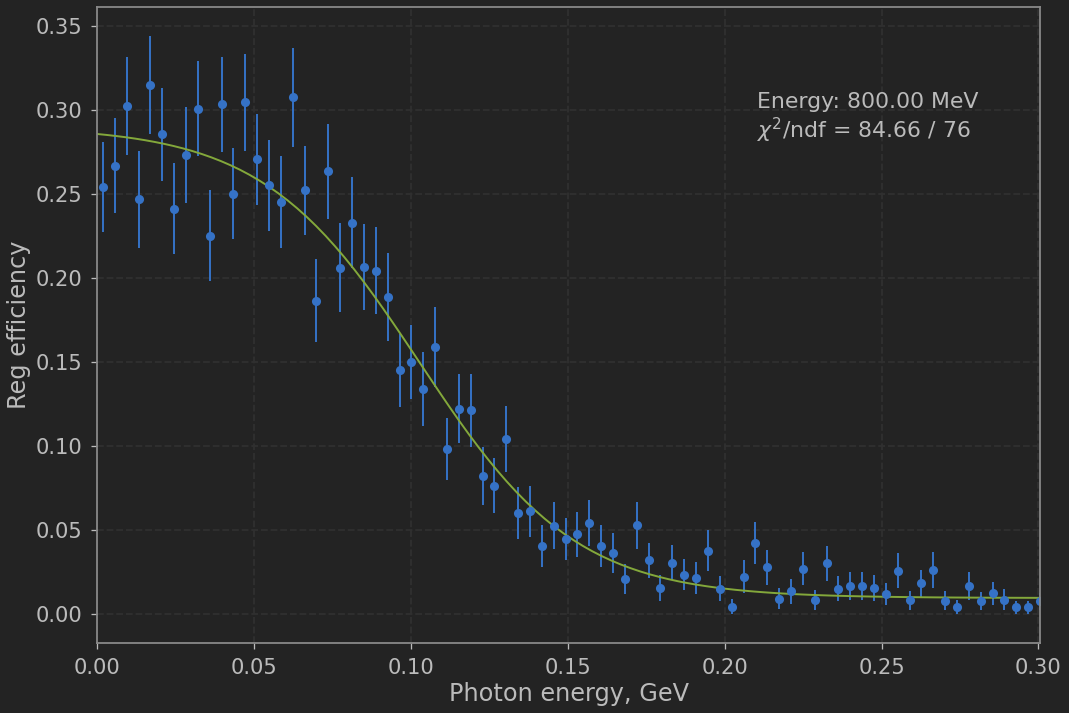

In [144]:
p.show_histo_by_name('800.00')
# plt.savefig('../Journal/outputs/images/allan_effreg_800_v7.png')

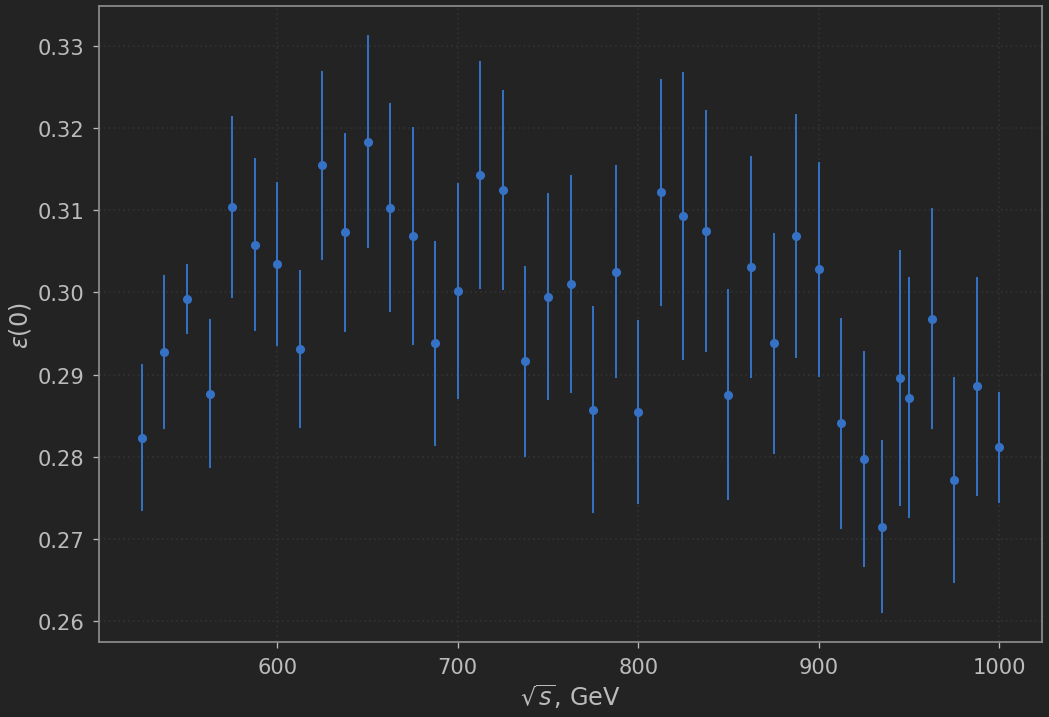

In [145]:
es, effs, errs = list(), list(), list()
for e in p.fit_results:
    eff = p.sigFunc(0, *p.fit_results[e][0])
    err1 = p.sigFunc(0, *(p.fit_results[e][0]+p.fit_results[e][1])) - eff
    err2 = eff - p.sigFunc(0, *(p.fit_results[e][0]-p.fit_results[e][1]))
    effs.append(eff)
    errs.append(err1)
    es.append(float(e))
plt.errorbar(es, effs, yerr=errs, fmt='o')
my_style('','$\sqrt{s}$, GeV', '$\\varepsilon(0)$')
eff_frame = pd.DataFrame({'name':es, 'eff':effs, 'err':errs})

In [20]:
def parametrizator(i=4):
    def chi2_parametrizator(k, b):
        return np.sum(((yp - (k*xe+b))/yperr)**2)
    #mu, s, c, N
    chindf_mean = 0
    xe = list()
    yp = list()
    yperr = list()
    for e in p.fit_results:
        chindf_mean += p.fit_results[e][2]/p.fit_results[e][3]
        if p.good_fits[e] == False:
            print('Bad fit at', e)
            continue
        xe.append(float(e)*2e-3)
        yp.append(p.fit_results[e][0][i])
        yperr.append(p.fit_results[e][1][i])
    xe, yp, yperr = np.array(xe), np.array(yp), np.array(yperr)
    print('Chi2/ndf mean:', chindf_mean/len(xe))
    plt.errorbar(xe, yp, yperr, fmt='o')
    m = iminuit.Minuit(chi2_parametrizator)
    print( m.migrad() )
    k, b = m.np_values()
    plt.plot([xe.min(), xe.max()], [k*xe.min()+b, k*xe.max()+b])
    return

Chi2/ndf mean: 1.0237518373953007
------------------------------------------------------------------
| FCN = 46.07                   |      Ncalls=38 (38 total)      |
| EDM = 2.5E-21 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  

/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: InitialParamWarning: Parameter k does not have initial value. Assume 0.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: InitialParamWarning: Parameter k is floating but does not have initial step size. Assume 1.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: InitialParamWarning: Parameter b does not have initial value. Assume 0.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
/store17/petrov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: InitialParamWarning: errordef is not given. Default to 1.


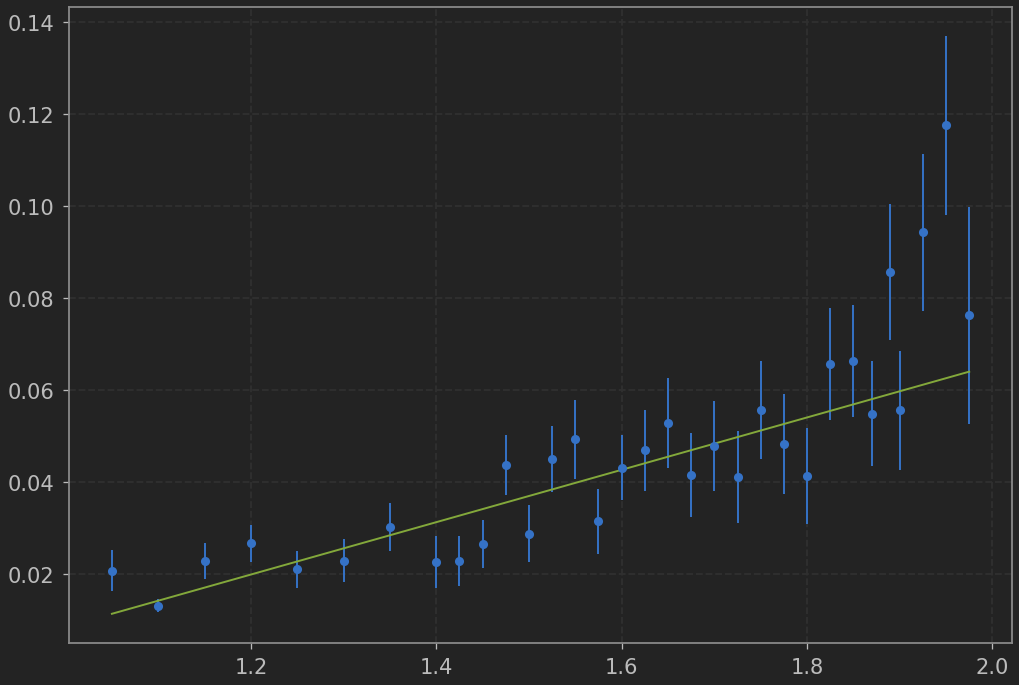

In [21]:
parametrizator(2)

In [146]:
r = RadCor()

In [147]:
xen = list()
xrad = list()
effs, errs = list(), list()
for en in p.fit_results:
    ps = p.fit_results[en][0]
    res = r.F_Radcor(x*5e2, y, float(en), ps, 1) 
#     print( 'Energy:', en, 'Rad:', res[0])
    xen.append(float(en))
    xrad.append(res[0])
rad_frame = pd.DataFrame({'name':xen, 'rad': xrad}).sort_values(by='name')

In [148]:
assert len(rad_frame) == len(eff_frame)
rad_frame = rad_frame.set_index('name').join(eff_frame.set_index('name')).reset_index()

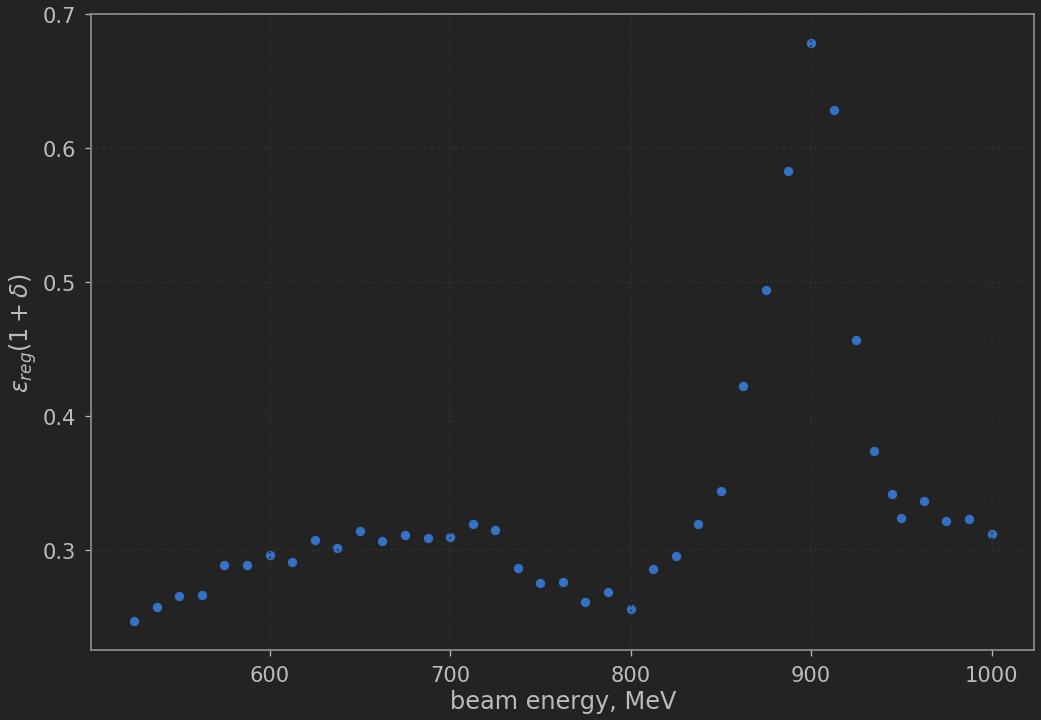

In [149]:
plt.scatter(rad_frame.name, rad_frame.rad)
my_style('','beam energy, MeV', '$\\varepsilon_{reg}(1+\delta)$')
# plt.savefig('../Journal/outputs/images/allan_effregradcor.png')

In [150]:
rad_frame.tail()

,name,rad,eff,err
35,950.0,0.323737,0.287215,0.014605
36,962.5,0.336692,0.296826,0.013478
37,975.0,0.321758,0.277165,0.012527
38,987.5,0.322680,0.288566,0.013291
39,1000.0,0.311598,0.281158,0.006753


In [151]:
# rad_frame.to_csv('./data/rad_frame.csv', index=False)

In [152]:
rad_frame_v7 = pd.read_csv('./data/rad_frame.csv')
rad_frame_v6 = pd.read_csv('./data/rad_frame_v6.csv')

In [153]:
rad_frame_v7

,name,rad,eff,err
0,525.0,0.246943,0.282331,0.008930
1,537.5,0.257595,0.292783,0.009364
2,550.0,0.265164,0.299180,0.004268
3,562.5,0.266508,0.287699,0.009009
4,575.0,0.288270,0.310379,0.011036
5,587.5,0.288571,0.305821,0.010530
6,600.0,0.296316,0.303492,0.009986
7,612.5,0.290831,0.293105,0.009643
8,625.0,0.306978,0.315498,0.011493
9,637.5,0.301655,0.307338,0.012096


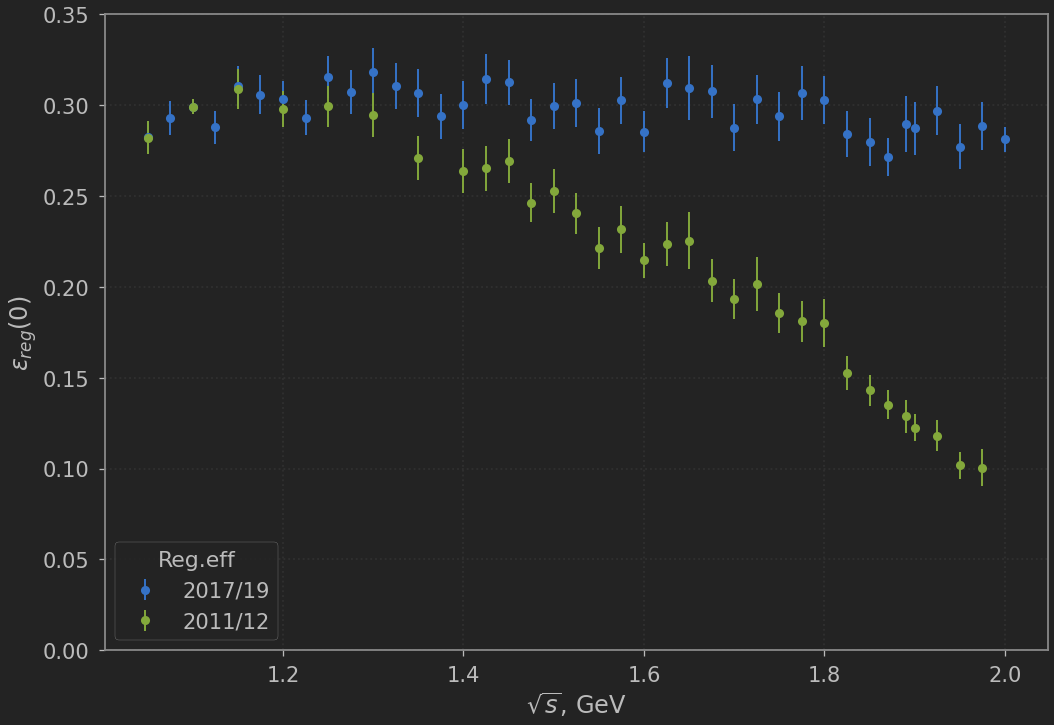

In [154]:
plt.errorbar(rad_frame_v7.name*2e-3, rad_frame_v7.eff, yerr=rad_frame_v7.err, fmt='o', label='2017/19')
plt.errorbar(rad_frame_v6.name*2e-3, rad_frame_v6.eff, yerr=rad_frame_v6.err, fmt='o', label='2011/12')
plt.legend(title='Reg.eff')
my_style('','$\sqrt{s}$, GeV', '$\\varepsilon_{reg}(0)$')
plt.ylim(0, 0.35);
# plt.savefig('../Journal/outputs/images/allan_regeff.png')

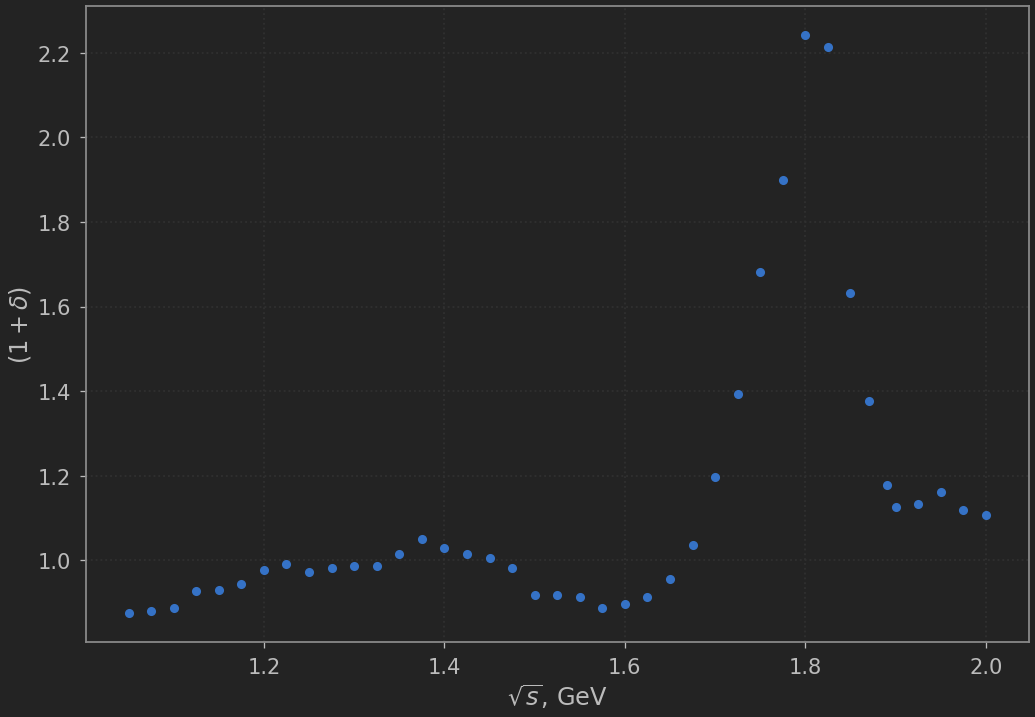

In [165]:
plt.errorbar(rad_frame_v7.name*2e-3, rad_frame_v7.rad/rad_frame_v7.eff, fmt='o')#, label='2017/19')
# plt.errorbar(rad_frame_v6.name*2e-3, rad_frame_v6.rad/rad_frame_v6.eff, fmt='o', label='2011/12')
# plt.legend()
my_style('','$\sqrt{s}$, GeV', '$(1+\\delta)$')
# plt.ylim(0, 0.35);
# plt.savefig('../Journal/outputs/images/allan_radcor.png')